In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import shutil
import time
import zipfile
from tqdm import tqdm
from PIL import Image, ImageFile, ImageFilter, ImageOps
from keras.utils import np_utils
from skimage import exposure
from skimage.feature import hog
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier

Using TensorFlow backend.


In [0]:
def loadDF_Images(path):
    ''' Return dataframe with images names, dogs breeds, and type of set,
    it also returns 2 arrays of images, one of the training set and the other
    of the test set

    Parameter:

    path: location of the folder
    '''

    labels = []
    ids = []
    type_set = []
    loadedImages_train = []
    loadedImages_test = []

    for breed in os.listdir(path):
        nbr_imgs = len(os.listdir(path + breed))

        for idx, image in zip(range(nbr_imgs), os.listdir(path + breed)):
            labels.append(breed.split('-')[1])
            ids.append(image)
            train_len = int(0.8*nbr_imgs)
            validation_len = int(0.9*nbr_imgs)

            if idx <= train_len - 1:
                type_set.append('training')
                img = Image.open(path + breed + '/'+  image)
                loadedImages_train.append(img)

            elif (idx > train_len - 1) and (idx <= validation_len - 1):
                type_set.append('validation')
                img_path = path + breed + '/'+  image
                loadedImages_test.append(img)

            else:
                type_set.append('test')
                img = Image.open(path + breed + '/'+  image)
                loadedImages_test.append(img)

    imgs = loadedImages_train + loadedImages_test  
    df = pd.DataFrame({'Id': ids, 'Image':imgs, 'Breed':labels, 'Type_set': type_set})

    return df, loadedImages_train, loadedImages_test    

In [0]:
#  load images

path = '/content/gdrive/My Drive/Images/'
df, imgs_train, imgs_test = loadDF_Images(path)

In [0]:
df

,Id,Image,Breed,Type_set
0,n02086079_21103.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Pekinese,training
1,n02086079_14307.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Pekinese,training
2,n02086079_11664.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Pekinese,training
3,n02086079_10373.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Pekinese,training
4,n02086079_884.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,Pekinese,training
...,...,...,...,...
20636,n02087046_420.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,toy_terrier,test
20637,n02087046_3953.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,toy_terrier,test
20638,n02087046_1658.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,toy_terrier,test
20639,n02087046_6166.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,toy_terrier,test


In [0]:
breeds = list(df['Breed'].unique())
nbr_breeds = len(breeds)
print('Number of breeds: ', nbr_breeds)

Number of breeds:  120


# Image pre-processing:

> Normalizing the size

> Denoising

> Normalize image contrast







Mean width for train images is 442.40 px
Mean height for train images is 385.31 px


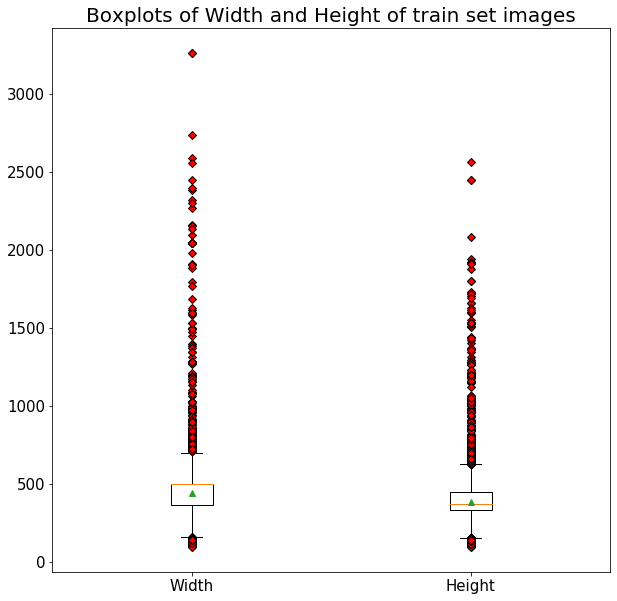

In [0]:
# Exploratory analysis of images size
# Boxplots of height and width

width_imgs_train = [img.size[0] for img in imgs_train]
height_imgs_train = [img.size[1] for img in imgs_train]
data = [width_imgs_train, height_imgs_train]
print('Mean width for train images is %.2f px' % np.mean(width_imgs_train))
print('Mean height for train images is %.2f px' % np.mean(height_imgs_train))

red_diamond = dict(markerfacecolor='r', marker='D')
fig, ax = plt.subplots(figsize=(10, 10))
plt.title("Boxplots of Width and Height of train set images", fontsize=20)
plt.xticks(size=15)
plt.yticks(size=15)
ax.boxplot(data, labels=['Width', 'Height'], flierprops=red_diamond, showmeans=True)
plt.show()


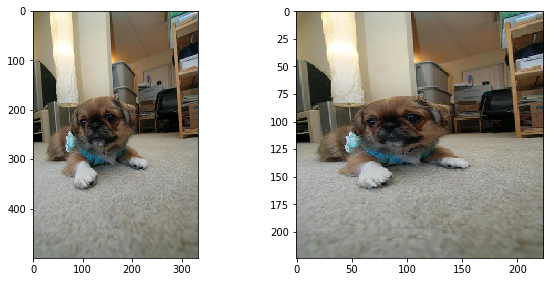

In [0]:
# Before/After (resize an image to 224x224 px)

STANDARD_SIZE = (224, 224) 
img = imgs_train[0]
new_img = img.resize(STANDARD_SIZE)

fig, ax = plt.subplots(figsize=(10, 10))
plt.figure(1)
plt.subplot(221)
plt.imshow(img)
plt.subplot(222)
plt.imshow(new_img)
plt.show()

In [0]:
# Normalize the data (resize each observation to 224x224 px)

STANDARD_SIZE = (224, 224) 
imgs_train = [img.resize(STANDARD_SIZE) for img in imgs_train]
imgs_test = [img.resize(STANDARD_SIZE) for img in imgs_test]
df.Image = [img.resize(STANDARD_SIZE) for img in df.Image]

In [0]:
# Convert all images to RGB

imgs_train = [img.convert(mode='RGB') for img in imgs_train]
imgs_test = [img.convert(mode='RGB') for img in imgs_test]
df.Image = [img.convert(mode='RGB') for img in df.Image]

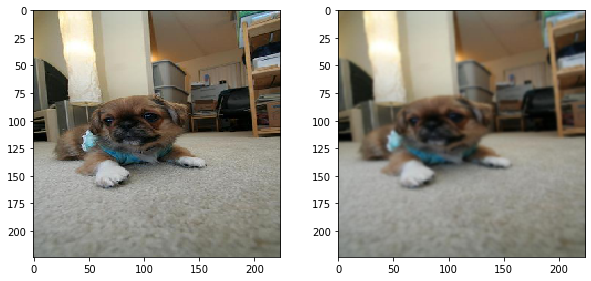

In [0]:
# gaussian filter (denoising)

img = imgs_train[0]
new_img = img.filter(ImageFilter.GaussianBlur(radius=1))

fig, ax = plt.subplots(figsize=(10, 10))
plt.figure(1)
plt.subplot(221)
plt.imshow(img)
plt.subplot(222)
plt.imshow(new_img)
plt.show()

In [0]:
def gaussian_filter(image):
    '''Apply a median filter on the image

    Parameter:

        image: the image to filter
    '''

    img = image.filter(ImageFilter.GaussianBlur(radius=1))

    return img

In [0]:
# Applying gaussian filter on training set images

imgs_train = [gaussian_filter(img) for img in imgs_train]
imgs_test = [gaussian_filter(img) for img in imgs_test]
df.Image = [gaussian_filter(img) for img in df.Image]

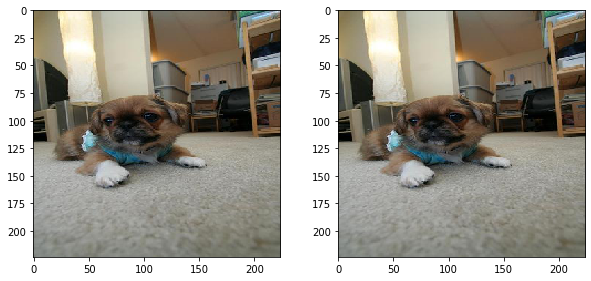

In [0]:
# autocontrast

img = imgs_train[0]
new_img = ImageOps.autocontrast(img)
fig, ax = plt.subplots(figsize=(10, 10))
plt.figure(1)
plt.subplot(221)
plt.imshow(img)
plt.subplot(222)
plt.imshow(new_img)
plt.show()

In [0]:
def autocontrast(image):
    '''Maximize (normalize) image contrast

    Parameter:

        image: the image to modify
    '''

    img = ImageOps.autocontrast(image)

    return img

In [0]:
# Applying autocontrast on training set images

imgs_train = [autocontrast(img) for img in imgs_train]
imgs_test = [autocontrast(img) for img in imgs_test]
df.Image = [autocontrast(img) for img in df.Image]

In [0]:
# Label encode string class Values (Breed)

for num, breed in enumerate(df['Breed'].unique()):
    df.loc[df['Breed']==breed, 'Breed_num'] = int(num)

In [0]:
df

,Id,Image,Breed,Type_set,Breed_num
0,n02086079_21103.jpg,<PIL.Image.Image image mode=RGB size=224x224 a...,Pekinese,training,0.0
1,n02086079_14307.jpg,<PIL.Image.Image image mode=RGB size=224x224 a...,Pekinese,training,0.0
2,n02086079_11664.jpg,<PIL.Image.Image image mode=RGB size=224x224 a...,Pekinese,training,0.0
3,n02086079_10373.jpg,<PIL.Image.Image image mode=RGB size=224x224 a...,Pekinese,training,0.0
4,n02086079_884.jpg,<PIL.Image.Image image mode=RGB size=224x224 a...,Pekinese,training,0.0
...,...,...,...,...,...
20636,n02087046_420.jpg,<PIL.Image.Image image mode=RGB size=224x224 a...,toy_terrier,test,119.0
20637,n02087046_3953.jpg,<PIL.Image.Image image mode=RGB size=224x224 a...,toy_terrier,test,119.0
20638,n02087046_1658.jpg,<PIL.Image.Image image mode=RGB size=224x224 a...,toy_terrier,test,119.0
20639,n02087046_6166.jpg,<PIL.Image.Image image mode=RGB size=224x224 a...,toy_terrier,test,119.0


# Extracting features (HOG) and creating BoW

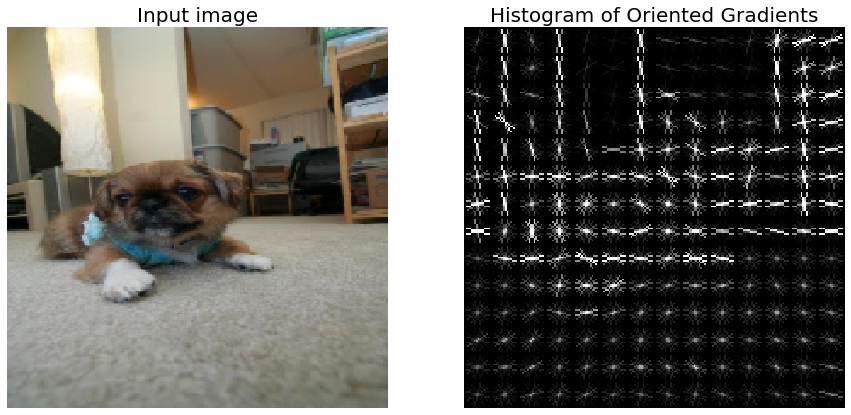

In [0]:
# Example of features extraction using HOG (Histogram of Oriented Gradients)

image = imgs_train[0]
fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(2, 2), visualize=True, multichannel=True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image', fontsize=20)

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients', fontsize=20)
plt.show()

In [0]:
len(fd)

5408

In [0]:
# Extracting HOG features and stacking all the features in list (one for train set,
# and another for test set)

feature_train = []
feature_test = []

for image in imgs_train:
    features = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(2, 2), visualize=False, multichannel=True)
    feature_train.append(features)

for image in imgs_test:
    features = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(2, 2), visualize=False, multichannel=True)
    feature_test.append(features)

In [0]:
# Extracting data from 10 random breeds

# To have reproductible results
np.random.seed(0)
sample = np.random.randint(10, size=119)
data = []

for num_breed in sample:
    for dog in np.where(df['Breed_num']==num_breed)[0]:
        data.append(dog)

df10 = df.iloc[data].copy()

# Extracting HOG features and stacking all the features in list (one for train set,
# and another for test set)

feature_train10 = []
feature_test10 = []

for image in df10['Image'].loc[df10['Type_set']=='training']:
    features = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(2, 2), visualize=False, multichannel=True)
    feature_train10.append(features)

for image in df10['Image'].loc[df10['Type_set']=='test']:
    features = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(2, 2), visualize=False, multichannel=True)
    feature_test10.append(features)

In [0]:
print(df10['Breed'].unique())

['cairn' 'Pekinese' 'Blenheim_spaniel' 'English_foxhound'
 'Tibetan_terrier' 'groenendael' 'American_Staffordshire_terrier'
 'Japanese_spaniel' 'pug' 'wire']


In [0]:
df10.head()

,Id,Image,Breed,Type_set,Breed_num
808,n02096177_5117.jpg,<PIL.Image.Image image mode=RGB size=224x224 a...,cairn,training,5.0
809,n02096177_170.jpg,<PIL.Image.Image image mode=RGB size=224x224 a...,cairn,training,5.0
810,n02096177_8324.jpg,<PIL.Image.Image image mode=RGB size=224x224 a...,cairn,training,5.0
811,n02096177_2935.jpg,<PIL.Image.Image image mode=RGB size=224x224 a...,cairn,training,5.0
812,n02096177_4916.jpg,<PIL.Image.Image image mode=RGB size=224x224 a...,cairn,training,5.0


Best kmeans silhouette is for: 600 clusters, with silhouette = 0.22


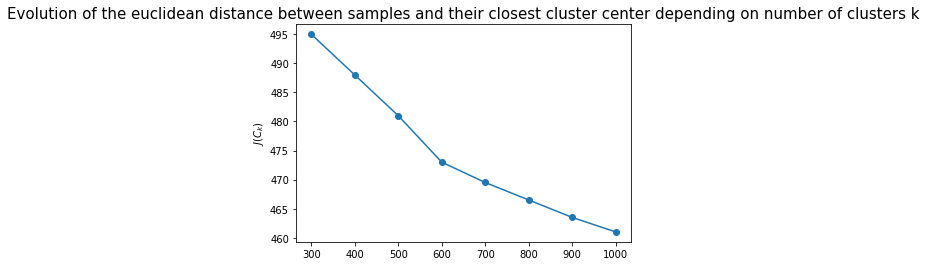

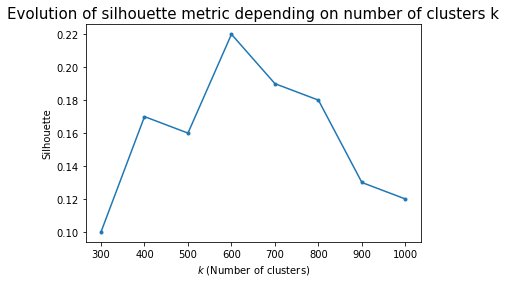

In [0]:
# Graphs showing the evolution of the euclidean distance between samples and their 
# closest cluster center and the evolution of silhouette metric, depending on number of cluster(k)

inertia = []
res = np.arange(8)
best = -1
best_n_clusters = 0

for idx, k in enumerate(np.linspace(300, 1000, 8, dtype=np.int16)):
    model = KMeans(n_clusters=k, random_state=0).fit(all_train_descriptors)
    inertia.append(np.sqrt(model.inertia_))
    res[idx] = silhouette_score(all_train_descriptors, model.labels_)

    if res[idx] > best:
        best = res[idx]
        best_n_clusters = k
    
print("Best kmeans silhouette is for: {} clusters, with silhouette = {}".format(best_n_clusters, best))

plt.plot(np.linspace(300, 1000, 8, dtype=np.int16), inertia, 'o-')
plt.title('Evolution of the euclidean distance between samples and their closest cluster center depending on number of clusters k',
          fontsize=15)
plt.ylabel('$J(C_k)$')
plt.show()

plt.plot(np.linspace(300, 1000, 8, dtype=np.int16), res, '.-')
plt.title('Evolution of silhouette metric depending on number of clusters k', fontsize=15)
plt.xlabel('$k$ (Number of clusters)')
plt.ylabel('Silhouette')
plt.show()

In [0]:
import cv2

def cluster_features(feature_list):

    """Cluster the training features using K-means and convert each
    set of descriptors in feature_list to a Visual Bag of Words histogram.

    Parameter:

        feature_list : list of lists of HOG descriptors
    """

    # compute set of cluster-reduced words for each image
    img_clustered_words = [model.predict(raw_words.reshape(1,-1)) for raw_words in feature_list]

    # finally make a histogram of clustered word counts for each image. These are the final features.
    img_bow_hist = [np.bincount(clustered_words, minlength=600) for clustered_words in img_clustered_words]

    # normalizes histogram
    cv2.normalize(img_bow_hist, img_bow_hist, norm_type=cv2.NORM_L2)
    
    X = img_bow_hist

    return X

In [0]:
all_train_descriptors = np.array(feature_train10)

# train kmeans on train descriptors
model = KMeans(n_clusters=600, random_state=0).fit(all_train_descriptors)

# Define training and test set for the 10 random breeds

X_train10 = cluster_features(feature_train10)
X_test10 = cluster_features(feature_test10)
y_train10 = df10['Breed_num'].loc[df10['Type_set']=='training']
y_test10 = df10['Breed_num'].loc[df10['Type_set']=='test']

# Part 1: Conventional classification method of images:

*   ## SVC
*   ## AdaBoost








In [0]:
# SVC (linear and kernel) using OVR on 10 breeds

c_vals = [0.0001, 0.01, 100, 1000]
svc_params = [{'estimator__C': c_vals, 'estimator__kernel': ['linear']},
              {'estimator__C': c_vals,
               'estimator__gamma': [0.01, 0.001],
               'estimator__kernel': ['rbf']}]
               
# Choose cross-validation techniques for the inner and outer loops,
# independently of the dataset
inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)

svc_gs10 = GridSearchCV(OneVsRestClassifier(SVC(random_state=0)), svc_params, cv=inner_cv,
                      scoring='accuracy')
svc_gs10.fit(X_train10, y_train10)

# Nested CV with parameter optimization
nested_score_svc = cross_val_score(svc_gs10, X=X_train10, y=y_train10, cv=outer_cv)*100

print("Best hyperparameters on the training set:", svc_gs10.best_params_)
print('Accuracy of SVC model: %.3f%%' % nested_score_svc.mean())
print('-----------------------------------------------')
print(svc_gs10.best_estimator_)

Best hyperparameters on the training set: {'estimator__C': 100, 'estimator__gamma': 0.01, 'estimator__kernel': 'rbf'}
Accuracy of SVC model: 54.525%
-----------------------------------------------
OneVsRestClassifier(estimator=SVC(C=100, cache_size=200, class_weight=None,
                                  coef0=0.0, decision_function_shape='ovr',
                                  degree=3, gamma=0.01, kernel='rbf',
                                  max_iter=-1, probability=False,
                                  random_state=0, shrinking=True, tol=0.001,
                                  verbose=False),
                    n_jobs=None)


In [0]:
# AdaBoost classifier on 10 breeds

ada_params={'n_estimators':[50, 100, 250], 'learning_rate':[1.0, 1.5]}

# Choose cross-validation techniques for the inner and outer loops,
# independently of the dataset
inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)

ada_gs10 = GridSearchCV(AdaBoostClassifier(random_state=0), ada_params, n_jobs=-1,
                      cv=inner_cv, scoring='accuracy')
ada_gs10.fit(X_train10, y_train10)

# Nested CV with parameter optimization
nested_score_ada = cross_val_score(ada_gs10, X=X_train10, y=y_train10, cv=outer_cv)*100

print("Best hyperparameters on the training set:", ada_gs10.best_params_)
print('Accuracy of AdaBoost model: %.3f%%' % nested_score_ada.mean())
print('--------------------------------------------------')
print(ada_gs10.best_estimator_)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best hyperparameters on the training set: {'learning_rate': 1.0, 'n_estimators': 250}
Accuracy of AdaBoost model: 31.409%
--------------------------------------------------
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=250, random_state=0)


In [0]:
# Accuracy of SVC model on test set (10 Breeds)

y_pred10 = svc_gs10.predict(X_test10)
print('Accuracy of SVC model on test set: %.3f%%' % (accuracy_score(y_test10, y_pred10)*100))

Accuracy of AdaBoost model on test set: 17.197%


In [0]:
all_train_descriptors = np.array(feature_train)

# train kmeans on train descriptors
model = KMeans(n_clusters=600, random_state=0).fit(all_train_descriptors)

# Define training and test set
X_train = cluster_features(feature_train)
X_test = cluster_features(feature_test)
y_train = df['Breed_num'][np.where(df['Type_set']=='training')[0]]
y_test = df['Breed_num'][np.where(df['Type_set']=='test')[0]]

In [0]:
# AdaBoost classifier

ada_params={'n_estimators':[50, 100, 250], 'learning_rate':[1.0, 1.5]}

# Choose cross-validation techniques for the inner and outer loops,
# independently of the dataset
inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)

ada_gs = GridSearchCV(AdaBoostClassifier(random_state=0), ada_params, n_jobs=-1,
                      cv=inner_cv, scoring='accuracy')
ada_gs.fit(X_train, y_train)

# Nested CV with parameter optimization
nested_score_ada = cross_val_score(ada_gs, X=X_train, y=y_train, cv=outer_cv)*100

print("Best hyperparameters on the training set:", ada_gs.best_params_)
print('Accuracy of AdaBoost model: %.3f%%' % nested_score_ada.mean())
print('--------------------------------------------------')
print(ada_gs.best_estimator_)

Best hyperparameters on the training set: {'learning_rate': 1.0, 'n_estimators': 100}
Accuracy of AdaBoost model: 1.844%
--------------------------------------------------
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=0)


In [0]:
# SVC (linear and kernel) using OVR

y_train = df['Breed_num'][np.where(df['Type_set']=='training')[0]]
y_test = df['Breed_num'][np.where(df['Type_set']=='test')[0]]

c_vals = [0.0001, 0.01, 100, 1000]
svc_params = [{'estimator__C': c_vals, 'estimator__kernel': ['linear']},
              {'estimator__C': c_vals,
               'estimator__gamma': [0.01, 0.001],
               'estimator__kernel': ['rbf']}]

# Choose cross-validation techniques for the inner and outer loops,
# independently of the dataset
inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)

svc_gs = GridSearchCV(OneVsRestClassifier(SVC(random_state=0)), svc_params, cv=inner_cv,
                      scoring='accuracy')
svc_gs.fit(X_train, y_train)

# Nested CV with parameter optimization
nested_score_svc = cross_val_score(svc_gs, X=X_train, y=y_train, cv=outer_cv)*100

print("Best hyperparameters on the training set:", svc_gs.best_params_)
print('Accuracy of SVC model: %.3f%%' % nested_score_svc.mean())
print('-----------------------------------------------')
print(svc_gs.best_estimator_)

Best hyperparameters on the training set: {'estimator__C': 1000, 'estimator__gamma': 0.01, 'estimator__kernel': 'rbf'}
Accuracy of SVC model: 1.020%
-----------------------------------------------
OneVsRestClassifier(estimator=SVC(C=1000, cache_size=200, class_weight=None,
                                  coef0=0.0, decision_function_shape='ovr',
                                  degree=3, gamma=0.01, kernel='rbf',
                                  max_iter=-1, probability=False,
                                  random_state=0, shrinking=True, tol=0.001,
                                  verbose=False),
                    n_jobs=None)


In [0]:
# Accuracy of AdaBoost model on test set

y_pred = ada_gs.predict(X_test)
print('Accuracy of AdaBoost model on test set: %.3f%%' % (accuracy_score(y_test, y_pred)*100))

Accuracy of AdaBoost model on test set: 1.206%


## Part 2: CNN (VGG-16) with and without transfer learning

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Input, Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, decode_predictions, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.preprocessing import image

In [0]:
def loadDF_Images_CNN(path):
    ''' Return dataframe with images names, dogs breeds, and type of set,
    it also returns 3 arrays of images (training, validation, test)

    Parameter:

    path: location of the folder
    '''

    labels = []
    ids = []
    type_set = []
    loadedImages_train = []
    loadedImages_validation = []
    loadedImages_test = []

    for breed in os.listdir(path):
        nbr_imgs = int(0.2*len(os.listdir(path + breed)))

        for idx, image_name in zip(range(nbr_imgs), os.listdir(path + breed)):
            labels.append(breed.split('-')[1])
            ids.append(path + breed + '/'+ image_name)
            train_len = int(0.8*nbr_imgs)
            validation_len = int(0.9*nbr_imgs)

            if idx <= train_len - 1:
                type_set.append('training')
                img_path = path + breed + '/'+  image_name
                img = image.load_img(img_path, target_size=(224, 224))
                x = image.img_to_array(img)
                loadedImages_train.append(x)

            elif (idx > train_len - 1) and (idx <= validation_len - 1):
                type_set.append('validation')
                img_path = path + breed + '/'+  image_name
                img = image.load_img(img_path, target_size=(224, 224))
                x = image.img_to_array(img)
                loadedImages_validation.append(x)

            else:
                type_set.append('test')
                img_path = path + breed + '/'+  image_name
                img = image.load_img(img_path, target_size=(224, 224))
                x = image.img_to_array(img)
                loadedImages_test.append(x)

    imgs = loadedImages_train + loadedImages_validation + loadedImages_test  
    df = pd.DataFrame({'Id': ids, 'Image':imgs, 'Breed':labels, 'Type_set': type_set})

    for num, breed in enumerate(df['Breed'].unique()):
        df.loc[df['Breed']==breed, 'Breed_num'] = int(num)

    return df,  np.array(loadedImages_train),  np.array(loadedImages_validation),  np.array(loadedImages_test)    

In [0]:
path = '/content/gdrive/My Drive/Images/'
df, Imgs_train, Imgs_validation, Imgs_test = loadDF_Images_CNN(path)

In [0]:
def sets_of_targets(dataframe):
    """ define the targets for the tensors in the different sets

    Parameter:
        dataframe: dataframe that contains information about the belonging of each tensor
    """
    
    train_targets = np_utils.to_categorical(
                    np.array(df['Breed_num'].loc[df['Type_set']=='training']), 120)
    validation_targets = np_utils.to_categorical(
                    np.array(df['Breed_num'].loc[df['Type_set']=='validation']), 120)
    test_targets = np_utils.to_categorical(
                    np.array(df['Breed_num'].loc[df['Type_set']=='test']), 120)
    
    return train_targets, validation_targets, test_targets

In [0]:
train_targets, validation_targets, test_targets = sets_of_targets(df)

In [0]:
indices_train = np.argsort(np.where(df['Type_set']=='training')[0])
indices_val = np.argsort(np.where(df['Type_set']=='validation')[0])
indices_test = np.argsort(np.where(df['Type_set']=='test')[0])

sorted_filenames_train = Imgs_train[indices_train]
sorted_filenames_validate = Imgs_validation[indices_val]
sorted_filenames_test = Imgs_test[indices_test]
sorted_labels_train = train_targets[indices_train]
sorted_labels_validate = validation_targets[indices_val]
sorted_labels_test = test_targets[indices_test]

## Pre-trained VGG16 model without transfer learning

In [0]:
# load the model
model = VGG16()

# predict the probability across all output classes
y_pred = model.predict(np.expand_dims(list_tensors_test[3], axis=0))

# convert the probabilities to class labels
label = decode_predictions(y_pred)

# retrieve the most likely result, e.g. highest probability
label = label[0][0]

# print the classification
print('%s (%.2f%%)' % (label[1], label[2]*100))
print('Top 3 :', decode_predictions(y_pred, top=3))

Pekinese (89.21%)
Top 3 : [[('n02086079', 'Pekinese', 0.89205277), ('n02085782', 'Japanese_spaniel', 0.07163223), ('n02086910', 'papillon', 0.030059587)]]


In [0]:
dog_breed_predictions = [model.predict(np.expand_dims(tensor, axis=0)) for 
                         tensor in list_tensors_test]

decode_dog_breed_predictions = [decode_predictions(dog_breed)[0][0][1] for 
                                dog_breed in dog_breed_predictions]

test_accuracy = 100*np.sum(np.array(decode_dog_breed_predictions)==np.array(
    df['Breed'].loc[df['Type_set']=='test']))/len(decode_dog_breed_predictions)

print('Test accuracy of the pre-trained VGG16 model without transfer learning: %.2f%%' % test_accuracy)

Test accuracy of the pre-trained VGG16 model without transfer learning: 61.84%


In [0]:
def preprocess(img):

    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    input_img = preprocess_input(np.expand_dims(img, axis=0))

    return input_img[0]

## Generate Bottleneck features

In [24]:
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
vgg16_full = VGG16(weights="imagenet", include_top=True, input_shape=(224, 224, 3))

# Extract the 2 fully-connected layers
fc1_layer = vgg16_full.get_layer("fc1")
fc2_layer = vgg16_full.get_layer("fc2")

train_datagen = ImageDataGenerator(preprocessing_function=preprocess)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess)

batch_size = 64

train_gen = train_datagen.flow(sorted_filenames_train, train_targets, 
                               batch_size=batch_size)
val_gen = val_datagen.flow(sorted_filenames_validate, validation_targets,
                           batch_size=batch_size)
test_gen = val_datagen.flow(sorted_filenames_test, test_targets,
                           batch_size=batch_size)

X_train = vgg16.predict_generator(train_gen, steps=16376//64, verbose=1)
X_val = vgg16.predict_generator(val_gen, steps=2052//64, verbose=1)
X_test = vgg16.predict_generator(test_gen, steps=2156//64, verbose=1)

inputs = Input(shape=(7,7,512))

# Turn off training vgg16
for layer in vgg16.layers:
    layer.trainable = False

fc1_layer.trainable = False
fc2_layer.trainable = False

x = Flatten()(inputs)
x = fc1_layer(x)
x = BatchNormalization()(x)

# dropout to make the model overfit less

x = Dropout(0.8)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.8)(x)
x = Dense(4096)(x)
x = fc2_layer(x)
x = BatchNormalization()(x)
x = Dropout(0.8)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.8)(x)
predictions = Dense(120, activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)
model.summary()

16/16 [==============================] - 29s 2s/step


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 7, 7, 512)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 4096)              102764544 
_________________________________________________________________
batch_normalization_5 (Batch (None, 4096)              16384     
_________________________________________________________________
dropout_5 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               2097664   
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)               2048

In [0]:
# Compile the model 
model.compile(loss="categorical_crossentropy",
                  optimizer=optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

y_train = sorted_labels_train[:len(X_train)]
y_val = sorted_labels_validate[:len(X_val)]
y_test = sorted_labels_test[:len(X_test)]

history = model.fit(X_train, y_train, batch_size=64, epochs=30, verbose=1, 
                    validation_data=(X_val, y_val))

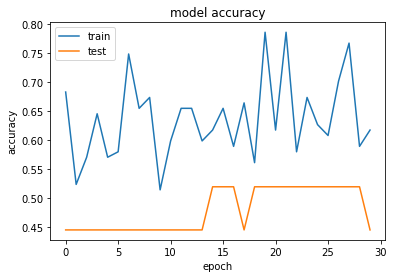

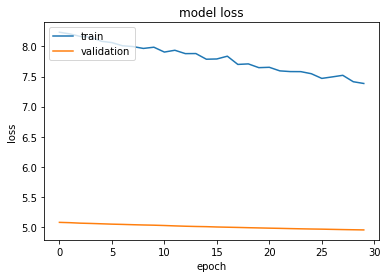

In [34]:
# summarize history for accuracy
plt.plot('acc')
plt.plot('val_acc')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Generate Bottleneck features (with data augmentation)

In [35]:
# load the model without fully-connected layers
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

vgg16_full = VGG16(weights="imagenet", include_top=True, input_shape=(224, 224, 3))

# Extract the 2 fully-connected layers
fc1_layer = vgg16_full.get_layer("fc1")
fc2_layer = vgg16_full.get_layer("fc2")

# Data Augmentation
train_datagen = ImageDataGenerator(shear_range=0.1, zoom_range=0.1, horizontal_flip=True, 
                                   rotation_range=10., fill_mode='reflect',
                                   width_shift_range = 0.2, height_shift_range = 0.2)
val_datagen = ImageDataGenerator(shear_range=0.1, zoom_range=0.1, horizontal_flip=True, 
                                   rotation_range=10., fill_mode='reflect',
                                   width_shift_range = 0.2, height_shift_range = 0.2)
test_datagen = ImageDataGenerator()

batch_size = 64

train_gen = train_datagen.flow(sorted_filenames_train, train_targets, 
                               batch_size=batch_size)
val_gen = val_datagen.flow(sorted_filenames_validate, validation_targets,
                           batch_size=batch_size)
test_gen = val_datagen.flow(sorted_filenames_test, test_targets,
                           batch_size=batch_size)

X_train = vgg16.predict_generator(train_gen, steps=16376//64, verbose=1)
X_val = vgg16.predict_generator(val_gen, steps=2052//64, verbose=1)
X_test = vgg16.predict_generator(test_gen, steps=2156//64, verbose=1)


inputs = Input(shape=(7,7,512))

# Turn off training vgg16
for layer in vgg16.layers:
    layer.trainable = False

fc1_layer.trainable = False
fc2_layer.trainable = False

x = Flatten()(inputs)
x = fc1_layer(x)
x = BatchNormalization()(x)

# dropout to make the model overfit less
x = Dropout(0.8)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.8)(x)
x = Dense(4096)(x)
x = fc2_layer(x) 
x = BatchNormalization()(x)
x = Dropout(0.8)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.8)(x)
predictions = Dense(120, activation='softmax')(x)

# define the new model
model = Model(inputs=inputs, outputs=predictions)
model.summary()

16/16 [==============================] - 30s 2s/step
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 7, 7, 512)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 4096)              102764544 
_________________________________________________________________
batch_normalization_9 (Batch (None, 4096)              16384     
_________________________________________________________________
dropout_9 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               2097664   
_________________________________________________________________
batch_

In [0]:
# Compile the model 
model.compile(loss="categorical_crossentropy",
                  optimizer=optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

y_train = sorted_labels_train[:len(X_train)]
y_val = sorted_labels_validate[:len(X_val)]
y_test = sorted_labels_test[:len(X_test)]

history = model.fit(X_train, y_train, batch_size=64, epochs=30, verbose=1, 
                    validation_data=(X_val, y_val))

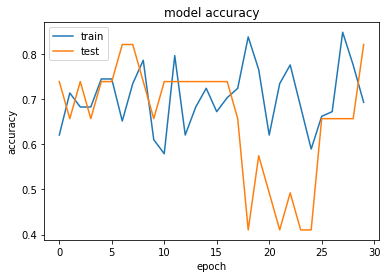

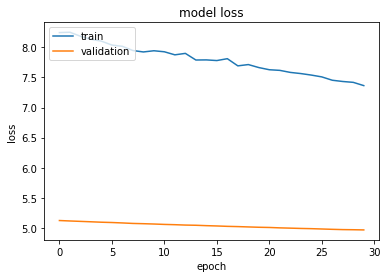

In [45]:
# summarize history for accuracy
plt.plot('acc')
plt.plot('val_acc')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [0]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(X_test))]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(y_test, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.2f%%' % test_accuracy)

Test accuracy: 78.31%


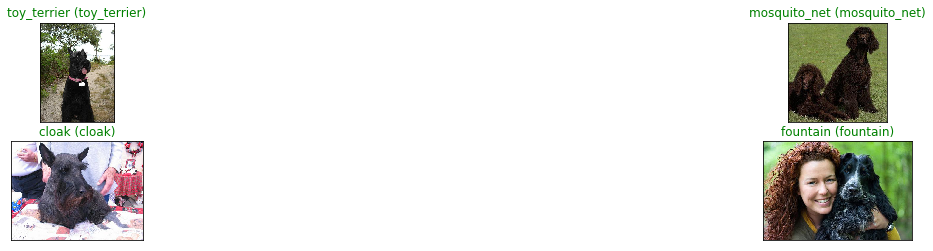

In [30]:
import random

samples = []
test_set_idx = np.where(df['Type_set']=='test')[0]

for sample in range(4):
    samples.append(random.choice(test_set_idx))

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(4):
    ax = fig.add_subplot(2, 2, idx+1, xticks=[], yticks=[])
    pred = model.predict(X_test[samples[idx]])

    # convert the probability to class label
    label = decode_predictions(pred)

    # retrieve the most likely result, i.e highest probability
    label = label[0][0][1]

    path_image = df['Id'][samples[idx]]
    breed = df['Breed'][samples[idx]]
    img = Image.open(path_image)
    ax.imshow(img)

    if str(label)==str(df['Breed'][samples[idx]]):
        colors = 'g' 
    else:
         colors = "r"

    ax.set_title("{} ({})".format(str(label), str(df['Breed'][samples[idx]])),
                                  color=colors)

In [0]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Input, Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, decode_predictions, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.preprocessing import image

# load the model without fully-connected layers
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

vgg16_full = VGG16(weights="imagenet", include_top=True, input_shape=(224, 224, 3))

# Extract the 2 fully-connected layers
fc1_layer = vgg16_full.get_layer("fc1")
fc2_layer = vgg16_full.get_layer("fc2")

# Data Augmentation
train_datagen = ImageDataGenerator(shear_range=0.1, zoom_range=0.1, horizontal_flip=True, 
                                   rotation_range=10., fill_mode='reflect',
                                   width_shift_range = 0.2, height_shift_range = 0.2)
val_datagen = ImageDataGenerator(shear_range=0.1, zoom_range=0.1, horizontal_flip=True, 
                                   rotation_range=10., fill_mode='reflect',
                                   width_shift_range = 0.2, height_shift_range = 0.2)
test_datagen = ImageDataGenerator()

batch_size = 64

train_gen = train_datagen.flow(sorted_filenames_train, train_targets, 
                               batch_size=batch_size)
val_gen = val_datagen.flow(sorted_filenames_validate, validation_targets,
                           batch_size=batch_size)
test_gen = val_datagen.flow(sorted_filenames_test, test_targets,
                           batch_size=batch_size)

X_train = vgg16.predict_generator(train_gen, steps=16376//64, verbose=1)
X_val = vgg16.predict_generator(val_gen, steps=2052//64, verbose=1)
X_test = vgg16.predict_generator(test_gen, steps=2156//64, verbose=1)


inputs = Input(shape=(7,7,512))

# Turn off training vgg16
for layer in vgg16.layers:
    layer.trainable = False

fc1_layer.trainable = False
fc2_layer.trainable = False

x = Flatten()(inputs)
x = fc1_layer(x)
x = BatchNormalization()(x)

# dropout to make the model overfit less
x = Dropout(0.8)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.8)(x)
x = Dense(4096)(x)
x = fc2_layer(x) 
x = BatchNormalization()(x)
x = Dropout(0.8)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.8)(x)
predictions = Dense(120, activation='softmax')(x)

# define the new model
model = Model(inputs=inputs, outputs=predictions)

model.compile(loss="categorical_crossentropy",
                  optimizer=optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

y_train = sorted_labels_train[:len(X_train)]
y_val = sorted_labels_validate[:len(X_val)]
y_test = sorted_labels_test[:len(X_test)]

model.fit(X_train, y_train, batch_size=64, epochs=30, verbose=1, 
                    validation_data=(X_val, y_val))

# Serialization of the model
pickle.dump(model, open('model.p', 'wb'))